In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
import copy
import pickle
import numba

In [2]:
# load subroutines and plotting settings
import params as par
import background as bg
from background import *
plt.rcParams.update(par.plot_params)

# Load data from GDM_FID.
τ_solve = pickle.load(open( "data/tau_solve.p", "rb" ) )
k_solve = pickle.load(open( "data/k_solve.p", "rb" ) )

wd_F = pickle.load(open( "data/w_d.p", "rb" ) )
Dwd_F = pickle.load(open( "data/Dw_d.p", "rb" ) )
cs2d_F = pickle.load(open( "data/cs2_d.p", "rb" ) )

δd = pickle.load(open( "data/delta_d.p", "rb" ) )
vd = pickle.load(open( "data/v_d.p", "rb" ) )
δɣ = pickle.load(open( "data/delta_g.p", "rb" ) )
vɣ = pickle.load(open( "data/v_g.p", "rb" ) )
Φ = pickle.load(open( "data/phi.p", "rb" ) )

(wd, Dwd, cs2d) =(wd_F, Dwd_F, cs2d_F)

In [3]:
@numba.njit()
def listint(y, x):
    # use trap rule to obtain a cumulative integral.
    # first value of output is always zero.
    N = len(x)
    h = np.diff(x)
    
    out = np.zeros(N)
    out[0] = 0

    for i in range(1,N):
        T = (y[i-1]+y[i])*h[i-1]/2
        out[i] = out[i-1]+T
    return out

@numba.njit()
def rand_orth(N):
    r = np.random.randn(N,N)
    Q,R = np.linalg.qr(r)
    U = np.diag((-1)**np.random.randint(1,3,size=N))*1.0
    return Q @ U

In [4]:
"""2 fluid"""

# set initial conditions
Φ0  = Φ[:,0] 
δɣ0 = δɣ[:,0] 
vɣ0 = vɣ[:,0] 
δd0 = δd[:,0] 
vd0 = vd[:,0] 

Y0 = np.array([Φ0, δɣ0, vɣ0, δd0, vd0])

@numba.jit(nopython=True)
def DY(τ, Y, wd, Dwd, Ωdi, Hi, ai):
        dY = np.zeros((5,K_SOLVE))
        Φ = Y[0,:]
        δɣ = Y[1,:]
        vɣ = Y[2,:]
        δd = Y[3,:]
        vd = Y[4,:]
           
        ybi = 1.68*ai*Ωb0/Ωr0

        Ωbi = Ωb0 * ai**-3.
        Ωɣi = Ωɣ0 * ai**-4.

        wdi = np.interp(τ, τ_solve, wd)
        Dwdi = np.interp(τ, τ_solve, Dwd)
        
        #interpolate cs2
        idx = np.searchsorted(τ_solve, τ) - 1
        d = (τ - τ_solve[idx]) / (τ_solve[idx + 1] - τ_solve[idx])
        cs2di = (1 - d) * cs2d[:,idx]   + cs2d[:,idx + 1] * d
        
        f = vd*Ωdi*(1+wdi) + 4./3.*Ωɣi*vɣ +  Ωbi*vɣ
        dY[0,:]  = -ℋi*Φ + (3/2.*H0**2.*ai**2/k_solve)*f
        dY[1,:] = -4./3.*k_solve*vɣ + 4*dY[0,:]
        dY[2,:] = (-ℋi*ybi*vɣ + k_solve*δɣ/3)/(
            4./3. + ybi) + k_solve*Φ
        dY[3,:] = -(1+wdi)*(k_solve*vd-3*dY[0,:]) -\
            3*ℋi*(cs2di-wdi)*δd
        dY[4,:] = -ℋi*(1-3*wdi)*vd - vd*Dwdi/(1+wdi) +\
            k_solve*δd*cs2di/(1+wdi) + k_solve*Φ
        return dY

In [5]:
Ωd_τ0 = Ωc(τ0) + Ων(τ0)

# compute stepsizes for RK4
stepsizes = np.diff(τ_solve)
τ_RK = np.interp(np.arange(2*N)/2,range(N), τ_solve)
a_list  =  a(τ_solve)
a_RK  =  a(τ_RK)
    

@numba.jit(nopython=True) # (NOTE: re-implement cumtrapz to put these back)
def solve(wd, Dwd): 
    # Update the background:
    Ωd_new = Ωd_τ0 * np.exp(-3*listint((1+wd)/a_list,a_list))
    H_new =  H0 *np.sqrt(Ωb0*a_list**-3 + Ωɣ0*a_list**-4 + Ωd_new + ΩΛ)*a_list
    τ_new =  listint(1/(a_list * H_new), a_list)+τ0
    
    Ωd_RK = np.interp(τ_RK, τ_new, Ωd_new)
    H_RK =  np.interp(τ_RK, τ_new, H_new)
    a_RK =  np.interp(τ_RK, τ_new, a_list)
    
    Y = np.zeros((len(τ_solve), 5, par.K_SOLVE))
    Y[0,:,:] = Y0
    for i, τi in enumerate(τ_solve[:-1]):
        # interpolate the new background quantities:        
        ss = stepsizes[i]
        k1 = ss*DY(τi,Y[i,:,:], wd, Dwd, Ωd_RK[2*i], H_RK[2*i], a_RK[2*i])
        k2 = ss*DY(τi+ss/2,Y[i,:,:]+k1/2, wd, Dwd, Ωd_RK[2*i+1], H_RK[2*i+1], a_RK[2*i+1])
        k3 = ss*DY(τi+ss/2,Y[i,:,:]+k2/2, wd, Dwd, Ωd_RK[2*i+1], H_RK[2*i+1], a_RK[2*i+1])
        k4 = ss*DY(τi+ss,Y[i,:,:]+k3, wd, Dwd, Ωd_RK[2*i+2], H_RK[2*i+2], a_RK[2*i+2])
        
        Y[i+1,:,:] = Y[i,:,:] + k1/6 + k2/3 + k3/3 + k4/6
    return Y

In [6]:
# k and l list for integration
k_list2  = np.linspace(k_low,k_high,K_INT)
l_list = np.array([i for i in range(2,50,1)]+[i for i in range(50,200,5)] + 
     [i for i in range(200, 2500, 20)])
L = len(l_list)

"""Precompute Bessel Functions"""
# check if they're already stored
if 'DJLK' not in globals():
    JLK = np.array([
        spherical_jn(l, k_list2*(τ_now-τ_rec))
                    for l in l_list])
    DJLK = np.array([
        spherical_jn(l, k_list2*(τ_now-τ_rec), derivative=True) 
        for l in l_list])


In [7]:
k_grid = np.broadcast_to(k_list2,(len(l_list),K_INT))
@numba.jit(nopython=True)
def get_Cl(wd, Dwd, params):
    As = params[0]
    # first compute mode evolution:
    Yf = solve(wd, Dwd)[-1,:,:]
    SW = Yf[0,:] + Yf[1,:]/4
    ISW = ΔΦ
    DOP = Yf[2,:]
    
    SWsd = (SW+ISW)*np.exp(-(k_solve*τs)**2)
    DOPsd = DOP*np.exp(-(k_solve*τs)**2)

    
    # get the power spectrum
    SWfill = np.interp(k_list2, k_solve, SW)
    DOPfill = np.interp(k_list2, k_solve, DOP)
    Dl = SWfill*JLK + DOPfill*(DJLK-JLK/(2*k_list2*(τ_now-τ_rec)))

    T = np.exp(-2*(k_list2*τs)**2 - (.03*k_list2*τ_rec)**2)
    Cl_itgd = Dl**2 *T /k_list2
    Cl = integrate.trapz(k_grid, Cl_itgd)
    norm =  4*np.pi *  As/(k_star**(ns-1)) * TCMB0**2 *(1/3 * τ_rec**2)**2
    Cl_normed = l_list*(l_list + 1)*Cl * norm
    return np.abs(Cl_normed) 

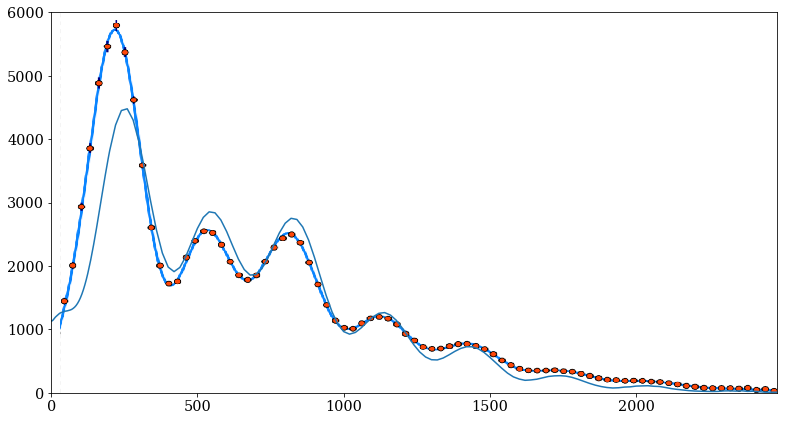

In [8]:
params_F = [.00007]
if True:
    """Compare to Planck 2015"""
    Cl0 = get_Cl(wd_F, Dwd_F,params_F)
    plt.plot(l_list, Cl0, zorder=1)
    im = plt.imread('img/Cl_planck_30p.PNG')
    plt.imshow(im, extent=[30,2500,0,6000] ,zorder=0,aspect='auto')
    plt.xlim(0,l_list[-1])
    plt.show()

In [9]:
%timeit Cl = get_Cl(wd_F, Dwd_F, params_F)

177 ms ± 3.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
